In [1]:
import tensorflow as tf

print("tensorflow version :", tf.__version__)

import matplotlib.pyplot as plt
import numpy as np

C:\Users\zabeeh\PycharmProjects\DeepLearning\v_general\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


tensorflow version : 2.20.0


In [2]:
import os

SEED = 42
IMG_SIZE = (48, 48)
BATCH_SIZE = 64
data_dir = os.path.join(os.getcwd(), 'data', 'Flower17', 'Flower17')

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir, validation_split=0.2, subset='training', seed=SEED, image_size=IMG_SIZE,
    batch_size=BATCH_SIZE, label_mode='int'
)

validation_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir, validation_split=0.2, subset='validation', seed=SEED, image_size=IMG_SIZE,
    batch_size=BATCH_SIZE, label_mode='int'
)

class_names = validation_ds.class_names
print(class_names)




Found 1360 files belonging to 17 classes.
Using 1088 files for training.
Found 1360 files belonging to 17 classes.
Using 272 files for validation.
['1', '10', '11', '12', '13', '14', '15', '16', '17', '2', '3', '4', '5', '6', '7', '8', '9']


In [3]:
from tensorflow.keras import layers

AUTOTUNE = tf.data.AUTOTUNE

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"), layers.RandomRotation(0.05), layers.RandomZoom(0.1)])


def preprocess_train(x, y):
    x = data_augmentation(x, training=True)
    x = x / 255.0
    return x, y


def preprocess_val(x, y):
    x = x / 255.0
    return x, y


training_ds = train_ds.map(preprocess_train, num_parallel_calls=AUTOTUNE).shuffle(1000).prefetch(AUTOTUNE)
validation_ds = validation_ds.map(preprocess_val, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)

from sklearn.utils.class_weight import compute_class_weight

y_train = np.concatenate([y.numpy() for _, y in training_ds])

class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)

class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)

Class weights: {0: np.float64(0.9552238805970149), 1: np.float64(1.0), 2: np.float64(1.032258064516129), 3: np.float64(0.9696969696969697), 4: np.float64(0.9411764705882353), 5: np.float64(1.0158730158730158), 6: np.float64(0.9696969696969697), 7: np.float64(0.9696969696969697), 8: np.float64(1.0491803278688525), 9: np.float64(1.0158730158730158), 10: np.float64(1.0), 11: np.float64(0.9696969696969697), 12: np.float64(0.9846153846153847), 13: np.float64(1.0158730158730158), 14: np.float64(1.1428571428571428), 15: np.float64(1.0158730158730158), 16: np.float64(0.9846153846153847)}


In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ELU, Input, Conv2D, MaxPool2D, BatchNormalization, Activation, Flatten, Dropout, \
    Dense
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(Input(shape=(48, 48, 3)))

# Block #1: first CONV => RELU => CONV => RELU => POOL
# model.add(Conv2D(32, (3, 3), padding="same", kernel_initializer="he_normal", input_shape=inputShape))
model.add(Conv2D(32, (3, 3), padding="same", kernel_initializer="he_normal"))
model.add(BatchNormalization(axis=-1))  # default is axis= -1
model.add(ELU())

model.add(Conv2D(32, (3, 3), kernel_initializer="he_normal", padding="same"))
model.add(BatchNormalization())
model.add(ELU())

model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Block #2: second CONV => RELU => CONV => RELU => POOL
model.add(Conv2D(64, (3, 3), kernel_initializer="he_normal", padding="same"))
model.add(BatchNormalization())
model.add(ELU())

model.add(Conv2D(64, (3, 3), kernel_initializer="he_normal", padding="same"))
model.add(BatchNormalization())
model.add(ELU())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Block #3: third CONV => RELU => CONV => RELU => POOL
model.add(Conv2D(128, (3, 3), kernel_initializer="he_normal", padding="same"))
model.add(BatchNormalization())
model.add(ELU())

model.add(Conv2D(128, (3, 3), kernel_initializer="he_normal", padding="same"))
model.add(BatchNormalization())
model.add(ELU())

model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Block #4: first set of FC => RELU layers
model.add(Flatten())
model.add(Dense(64, kernel_initializer="he_normal"))
model.add(BatchNormalization())
model.add(ELU())
model.add(Dropout(0.5))

# Block #6: second set of FC => RELU layers
model.add(Dense(64, kernel_initializer="he_normal"))
model.add(BatchNormalization())
model.add(ELU())

model.add(Dropout(0.5))

# Block #7: softmax classifier
model.add(Dense(17, kernel_initializer="he_normal", activation='softmax'))

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ elu (ELU)                       │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ elu_1 (ELU)                     │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ elu_2 (ELU)                     │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ elu_3 (ELU)                     │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ elu_4 (ELU)                     │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ elu_5 (ELU)                     │ (None, 12, 12, 128)    │             

 Total params: 589,553 (2.25 MB)

 Trainable params: 588,401 (2.24 MB)

 Non-trainable params: 1,152 (4.50 KB)

In [9]:
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger

opt = SGD(lr=0.01, decay=0.01 / 40, momentum=0.9, nesterov=True)
model.compile(optimizer=Adam(learning_rate=1e-3), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

callbacks = [ModelCheckpoint("Flower17.keras", save_best_only=True, monitor="val_loss"),
             CSVLogger("training_log.csv")]

history = model.fit(training_ds, validation_data=validation_ds, epochs=2,
                    callbacks=callbacks, class_weight=class_weights, verbose=1)

loss, acc = model.evaluate(validation_ds)
print(f"Accuracy: {acc * 100:.2f}%")

model_path_dir = os.path.join(os.getcwd(), 'data', 'Flower17')
os.makedirs(model_path_dir, exist_ok=True)

model_path = os.path.join(model_path_dir, "model.keras")
model.save(model_path)
# model.save("model", save_format="tf")
# model.save('model.h5')

Epoch 1/2
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - accuracy: 0.4936 - loss: 1.4689 - val_accuracy: 0.4338 - val_loss: 1.9800
Epoch 2/2
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 0.5211 - loss: 1.4073 - val_accuracy: 0.5221 - val_loss: 1.3382
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5221 - loss: 1.3382
Accuracy: 52.21%


In [10]:
from sklearn.metrics import classification_report

y_true = []

for _, labels in validation_ds:
    y_true.extend(labels.numpy())

y_true = np.array(y_true)

y_pred_probs = model.predict(validation_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

print(classification_report(y_true, y_pred, target_names=class_names))

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
              precision    recall  f1-score   support

           1       0.25      0.08      0.12        13
          10       0.04      0.06      0.05        16
          11       0.03      0.06      0.04        18
          12       0.03      0.07      0.05        14
          13       0.00      0.00      0.00        12
          14       0.00      0.00      0.00        17
          15       0.00      0.00      0.00        14
          16       0.20      0.07      0.11        14
          17       0.07      0.05      0.06        19
           2       0.17      0.06      0.09        17
           3       0.00      0.00      0.00        16
           4       0.00      0.00      0.00        14
           5       0.17      0.33      0.22        15
           6       0.25      0.18      0.21        17
           7       0.06      0.12      0.08        24
           8       0.33      0.06      0.10        17
           9       0.00      0.00      0.00

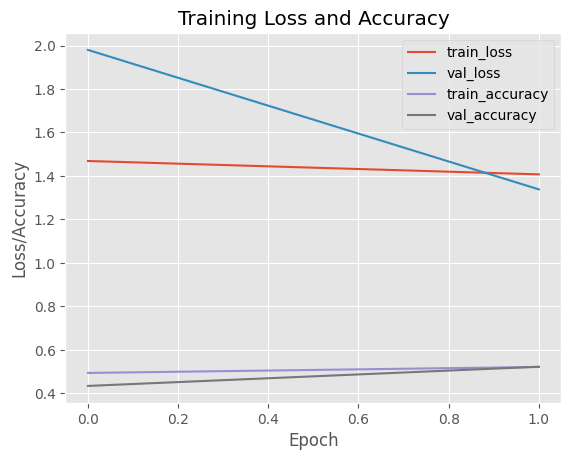

In [11]:
import matplotlib.pyplot as plt

epochs = range(1, len(history.history["loss"]) + 1)

plt.figure("Plotting of loss / accuracy")
plt.style.use("ggplot")
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.plot(history.history["accuracy"], label="train_accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.title("Training Loss and Accuracy")
plt.legend()
plt.show()


# Transfer Learning

In [ ]:
from utils.CNN_FCheadnet import FCHeadNet
from keras.optimizers import RMSprop
from keras.applications import VGG16
from keras.layers import Input
from keras.models import Model

baseModel = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

headModel = FCHeadNet.build(baseModel, len(class_names), 256)

model = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
    layer.trainable = False

model.compile(loss="categorical_crossentropy", optimizer=RMSprop(learning_rate=0.001), metrics=["accuracy"])

model.fit_generator(aug.flow(trainX, trainY, batch_size=8),  # batch size shuld be multipleof 2 32,64,128
                    validation_data=(testX, testY), epochs=25,
                    steps_per_epoch=len(trainX) // 32, verbose=1)

# evaluate the network after initialization
print("[INFO] evaluating after initialization...")
predictions = model.predict(testX, batch_size=8)  # batch size 32 original by book
print(classification_report(testY.argmax(axis=1),
                            predictions.argmax(axis=1), target_names=classNames))

# now that the head FC layers have been trained/initialized, lets
# unfreeze the final set of CONV layers and make them trainable
for layer in baseModel.layers[15:]:
    layer.trainable = True

# for the changes to the model to take affect we need to recompile
# the model, this time using SGD with a *very* small learning rate
print("[INFO] re-compiling model...")
opt = SGD(lr=0.001)
model.compile(loss="categorical_crossentropy", optimizer=opt,
              metrics=["accuracy"])

# train the model again, this time fine-tuning *both* the final set
# of CONV layers along with our set of FC layers
print("[INFO] fine-tuning model...")
model.fit_generator(aug.flow(trainX, trainY, batch_size=8),  # batch size 32 as per book
                    validation_data=(testX, testY), epochs=100,
                    steps_per_epoch=len(trainX) // 32, verbose=1)

# evaluate the network on the fine-tuned model
print("[INFO] evaluating after fine-tuning...")
predictions = model.predict(testX, batch_size=8)  # batch size  32 as per book
print(classification_report(testY.argmax(axis=1),
                            predictions.argmax(axis=1), target_names=classNames))

# save the model to disk
print("[INFO] serializing model...")
model.save("5_finetune_Flower17.model")
